In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
f_temp = pd.read_csv("data/Fem_Temp.csv")
f_act = pd.read_csv("data/Fem_Act.csv")
m_temp = pd.read_csv("data/Male_Temp.csv")
m_act = pd.read_csv("data/Male_Act.csv")

# Add implicit time index
f_temp['Minute'] = f_temp.index
f_act['Minute'] = f_act.index
m_temp['Minute'] = m_temp.index
m_act['Minute'] = m_act.index

# Convert to long format
f_temp_long = f_temp.melt(id_vars='Minute', var_name='Mouse', value_name='Temp')
f_act_long = f_act.melt(id_vars='Minute', var_name='Mouse', value_name='Activity')
m_temp_long = m_temp.melt(id_vars='Minute', var_name='Mouse', value_name='Temp')
m_act_long = m_act.melt(id_vars='Minute', var_name='Mouse', value_name='Activity')

# Merge temp + activity
f_df = pd.merge(f_temp_long, f_act_long, on=['Minute', 'Mouse'])
f_df['Sex'] = 'F'

m_df = pd.merge(m_temp_long, m_act_long, on=['Minute', 'Mouse'])
m_df['Sex'] = 'M'

# Combine all
df = pd.concat([f_df, m_df], ignore_index=True)

# Derive time-based columns
df['Day'] = df['Minute'] // 1440
df['MinuteOfDay'] = df['Minute'] % 1440
df['Light'] = df['MinuteOfDay'].apply(lambda x: 'Dark' if x < 720 else 'Light')
df['Estrus'] = df.apply(lambda row: 'Yes' if row['Sex'] == 'F' and row['Day'] in [2, 6, 10, 14] else 'No', axis=1)


In [2]:
df

,Minute,Mouse,Temp,Activity,Sex,Day,MinuteOfDay,Light,Estrus
0,0,f1,37.11,25.0,F,0,0,Dark,No
1,1,f1,37.13,26.0,F,0,1,Dark,No
2,2,f1,37.19,35.0,F,0,2,Dark,No
3,3,f1,37.20,63.0,F,0,3,Dark,No
4,4,f1,37.22,0.0,F,0,4,Dark,No
...,...,...,...,...,...,...,...,...,...
524155,20155,m13,37.00,0.0,M,13,1435,Light,No
524156,20156,m13,37.00,0.0,M,13,1436,Light,No
524157,20157,m13,37.00,0.0,M,13,1437,Light,No
524158,20158,m13,37.00,0.0,M,13,1438,Light,No


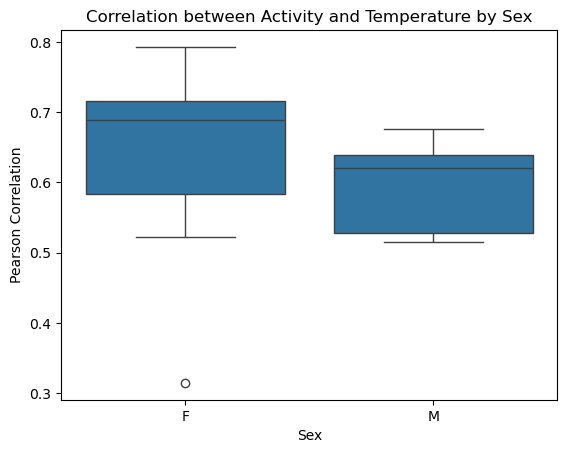

In [3]:
# Compute correlation for each mouse
correlations = df.groupby(['Mouse'])[['Activity', 'Temp']].corr().iloc[0::2, -1].reset_index()
correlations.columns = ['Mouse', 'Feature', 'Correlation']

# Add Sex info (assuming mouse names start with 'f' or 'm')
correlations['Sex'] = correlations['Mouse'].apply(lambda x: 'F' if x.startswith('f') else 'M')

# Boxplot by sex
sns.boxplot(x='Sex', y='Correlation', data=correlations)
plt.title("Correlation between Activity and Temperature by Sex")
plt.ylabel("Pearson Correlation")
plt.show()


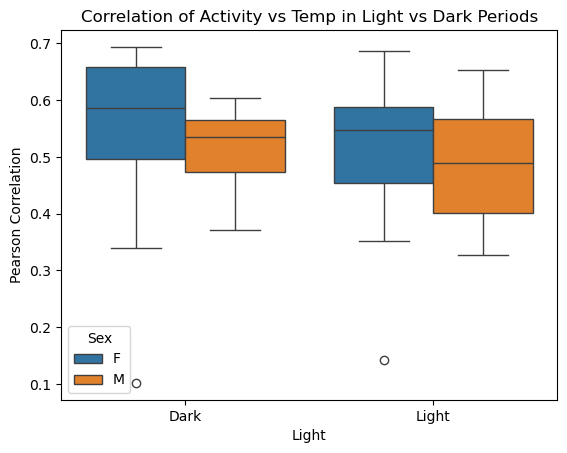

In [4]:
# Group by Mouse and Light condition, then compute correlation
light_corrs = (
    df.groupby(['Mouse', 'Light'])[['Activity', 'Temp']]
    .corr().iloc[0::2, -1]
    .reset_index()
)
light_corrs.columns = ['Mouse', 'Light', 'Feature', 'Correlation']
light_corrs['Sex'] = light_corrs['Mouse'].apply(lambda x: 'F' if x.startswith('f') else 'M')

# Boxplot: light vs. dark
sns.boxplot(x='Light', y='Correlation', hue='Sex', data=light_corrs)
plt.title("Correlation of Activity vs Temp in Light vs Dark Periods")
plt.ylabel("Pearson Correlation")
plt.show()


/var/folders/91/fp6glpk532556sb9f9_v4gp80000gn/T/ipykernel_18564/376062022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fem['MouseDay'] = df_fem['Mouse'] + "_d" + df_fem['Day'].astype(str)


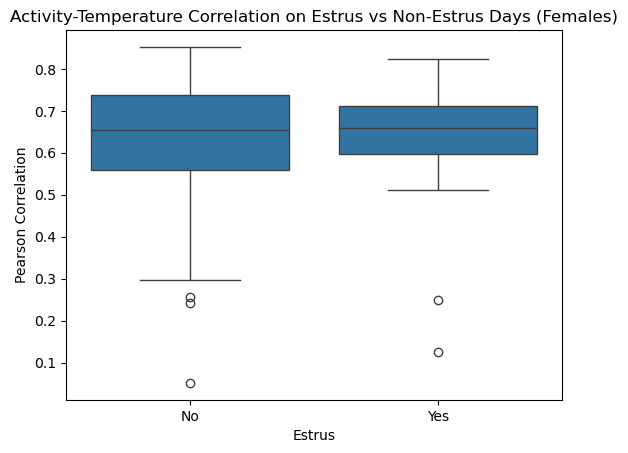

In [5]:
# Female-only correlation by estrus state per mouse
df_fem = df[df['Sex'] == 'F']

# Create a new label: Mouse-Day group (since estrus is at day level)
df_fem['MouseDay'] = df_fem['Mouse'] + "_d" + df_fem['Day'].astype(str)

# Group by Mouse-Day and Estrus, then compute correlation
estrus_corrs = (
    df_fem.groupby(['MouseDay', 'Estrus'])[['Activity', 'Temp']]
    .corr().iloc[0::2, -1]
    .reset_index()
)

estrus_corrs.columns = ['MouseDay', 'Estrus', 'Feature', 'Correlation']

# Plot
sns.boxplot(x='Estrus', y='Correlation', data=estrus_corrs)
plt.title("Activity-Temperature Correlation on Estrus vs Non-Estrus Days (Females)")
plt.ylabel("Pearson Correlation")
plt.show()


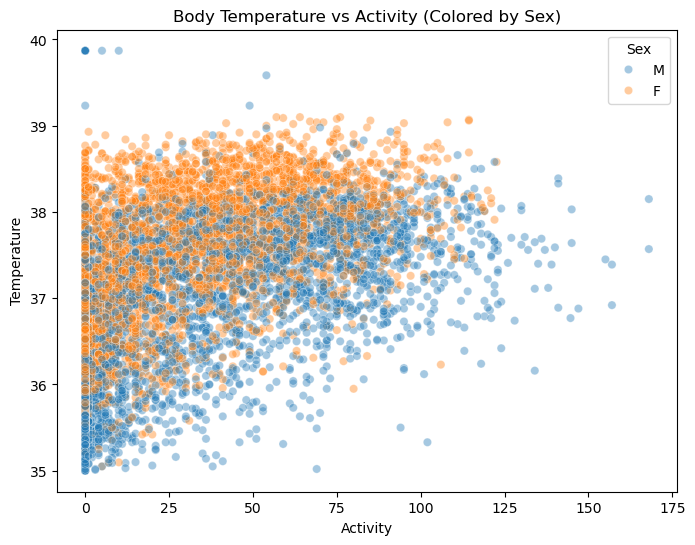

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample 10,000 points for plotting clarity
sample_df = df.sample(10000)

plt.figure(figsize=(8,6))
sns.scatterplot(data=sample_df, x='Activity', y='Temp', hue='Sex', alpha=0.4)
plt.title("Body Temperature vs Activity (Colored by Sex)")
plt.xlabel("Activity")
plt.ylabel("Temperature")
plt.show()


<Figure size 800x600 with 0 Axes>

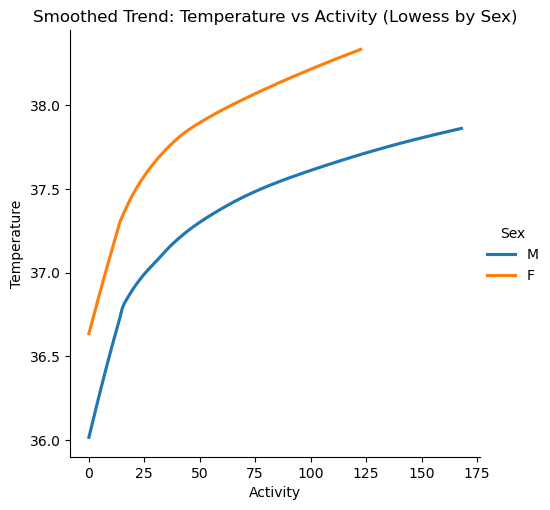

In [8]:
plt.figure(figsize=(8,6))
sns.lmplot(data=sample_df, x='Activity', y='Temp', hue='Sex', lowess=True, scatter=False)
plt.title("Smoothed Trend: Temperature vs Activity (Lowess by Sex)")
plt.xlabel("Activity")
plt.ylabel("Temperature")
plt.show()


/var/folders/91/fp6glpk532556sb9f9_v4gp80000gn/T/ipykernel_18564/2735754446.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby(['ActivityBin', 'Sex'])['Temp'].mean().reset_index()


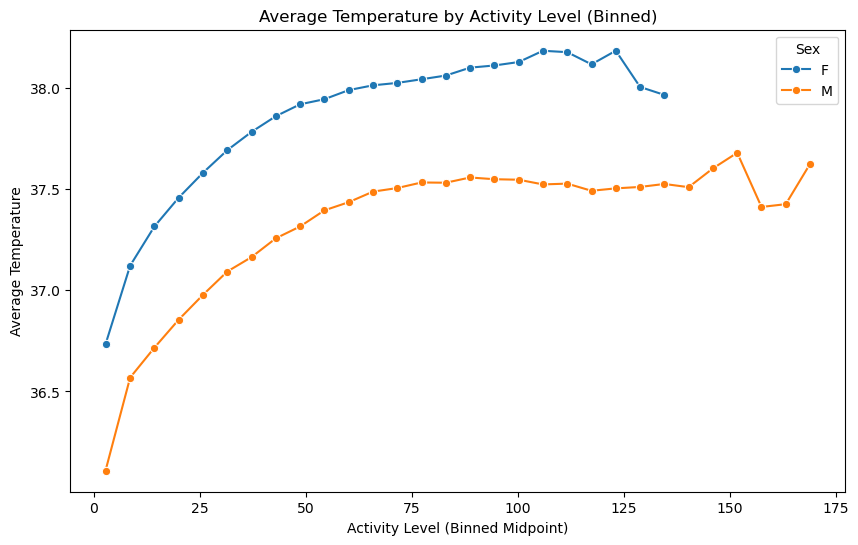

In [9]:
# Bin activity into ranges (e.g. 0–10, 10–20, etc.)
df['ActivityBin'] = pd.cut(df['Activity'], bins=30)

# Calculate mean temp per bin and sex
bin_avg = df.groupby(['ActivityBin', 'Sex'])['Temp'].mean().reset_index()
bin_avg['ActivityMid'] = bin_avg['ActivityBin'].apply(lambda x: x.mid)

plt.figure(figsize=(10,6))
sns.lineplot(data=bin_avg, x='ActivityMid', y='Temp', hue='Sex', marker='o')
plt.title("Average Temperature by Activity Level (Binned)")
plt.xlabel("Activity Level (Binned Midpoint)")
plt.ylabel("Average Temperature")
plt.show()


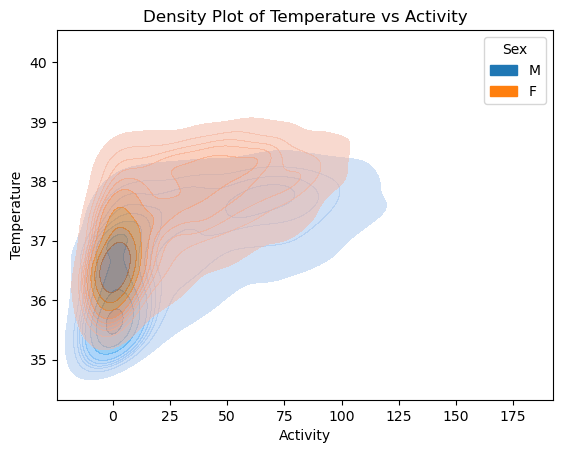

In [10]:
sns.kdeplot(data=sample_df, x='Activity', y='Temp', hue='Sex', fill=True, alpha=0.5)
plt.title("Density Plot of Temperature vs Activity")
plt.xlabel("Activity")
plt.ylabel("Temperature")
plt.show()
